# Timelag Analysis: Heating Cases
In this notebook, we'll compare the timelags across our several different heating cases:
* cooling
* random nanoflares
* high-frequency nanoflares
* intermediate-frequency nanoflares
* low-frequency nanoflares

We'll do this in a basic way, just comparing the flattened distributions of the timelags. The timelags themselves have been computed elsewhere.

In [24]:
import os
import sys

import numpy as np
from scipy.interpolate import splev,interp1d,splprep
import scipy.stats
import h5py
import dask
import dask.array
import dask.distributed
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map,GenericMap
from astropy.coordinates import SkyCoord
import astropy.units as u

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import plot_aia_channels

sys.path.append('../scripts/')
from idl_colormaps import bgry_004_idl_cmap

%matplotlib inline

Plot the AIA temperature responses for reference.

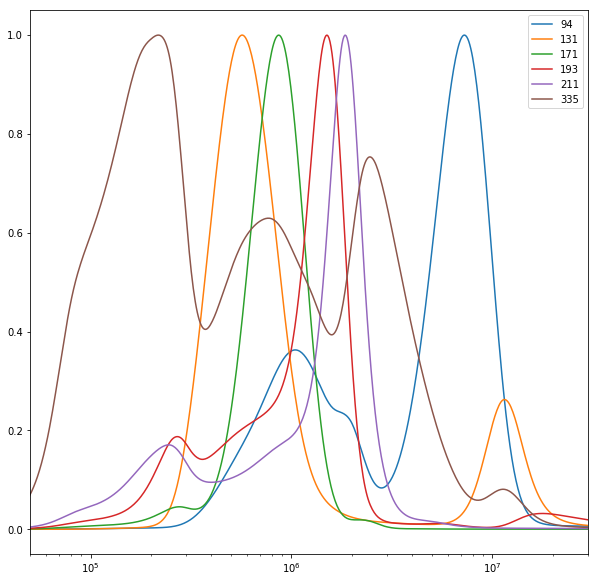

In [21]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
temperature_grid = np.logspace(4,9,1000)
aia_instr = InstrumentSDOAIA([0,1]*u.s,None)
for channel in aia_instr.channels:
    resp = splev(temperature_grid, channel['temperature_response_spline'])
    ax.plot(temperature_grid,resp/resp.max(),
            label=channel['name'])
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim(2e-29,3e-24)
ax.set_xlim(5e4,3e7)
ax.legend()

## Load Data
Load all of the timelag maps for all of the different heating cases and channel pairs.

In [59]:
heating = ['high_frequency/nei','intermediate_frequency/nei','low_frequency/nei',
           'cooling_outofphase_long/nei','cooling/nei','observational_data']
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]
timelag_maps_root_path = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{heating}/timelags/{type}_{c0}_{c1}.fits'

In [60]:
timelags,correlations = {},{}
for h in heating:
    timelags[h],correlations[h] = {},{}
    for c0,c1 in channel_pairs:
        timelags[h][f'{c0}_{c1}'] = Map(timelag_maps_root_path.format(heating=h,type='timelag',c0=c0,c1=c1))
        correlations[h][f'{c0}_{c1}'] = Map(timelag_maps_root_path.format(heating=h,type='correlation',c0=c0,c1=c1))

## Visualizing the Maps

Now plot all the heating models and compare across channel pairs.

In [63]:
titles = {'high_frequency/nei': 'High', 'intermediate_frequency/nei': 'Intermediate', 'low_frequency/nei': 'Low',
          'cooling_outofphase_long/nei': 'Random', 'cooling/nei': 'Cooling', 'observational_data': 'Observed'}

In [64]:
correlation_cutoff = 500.0

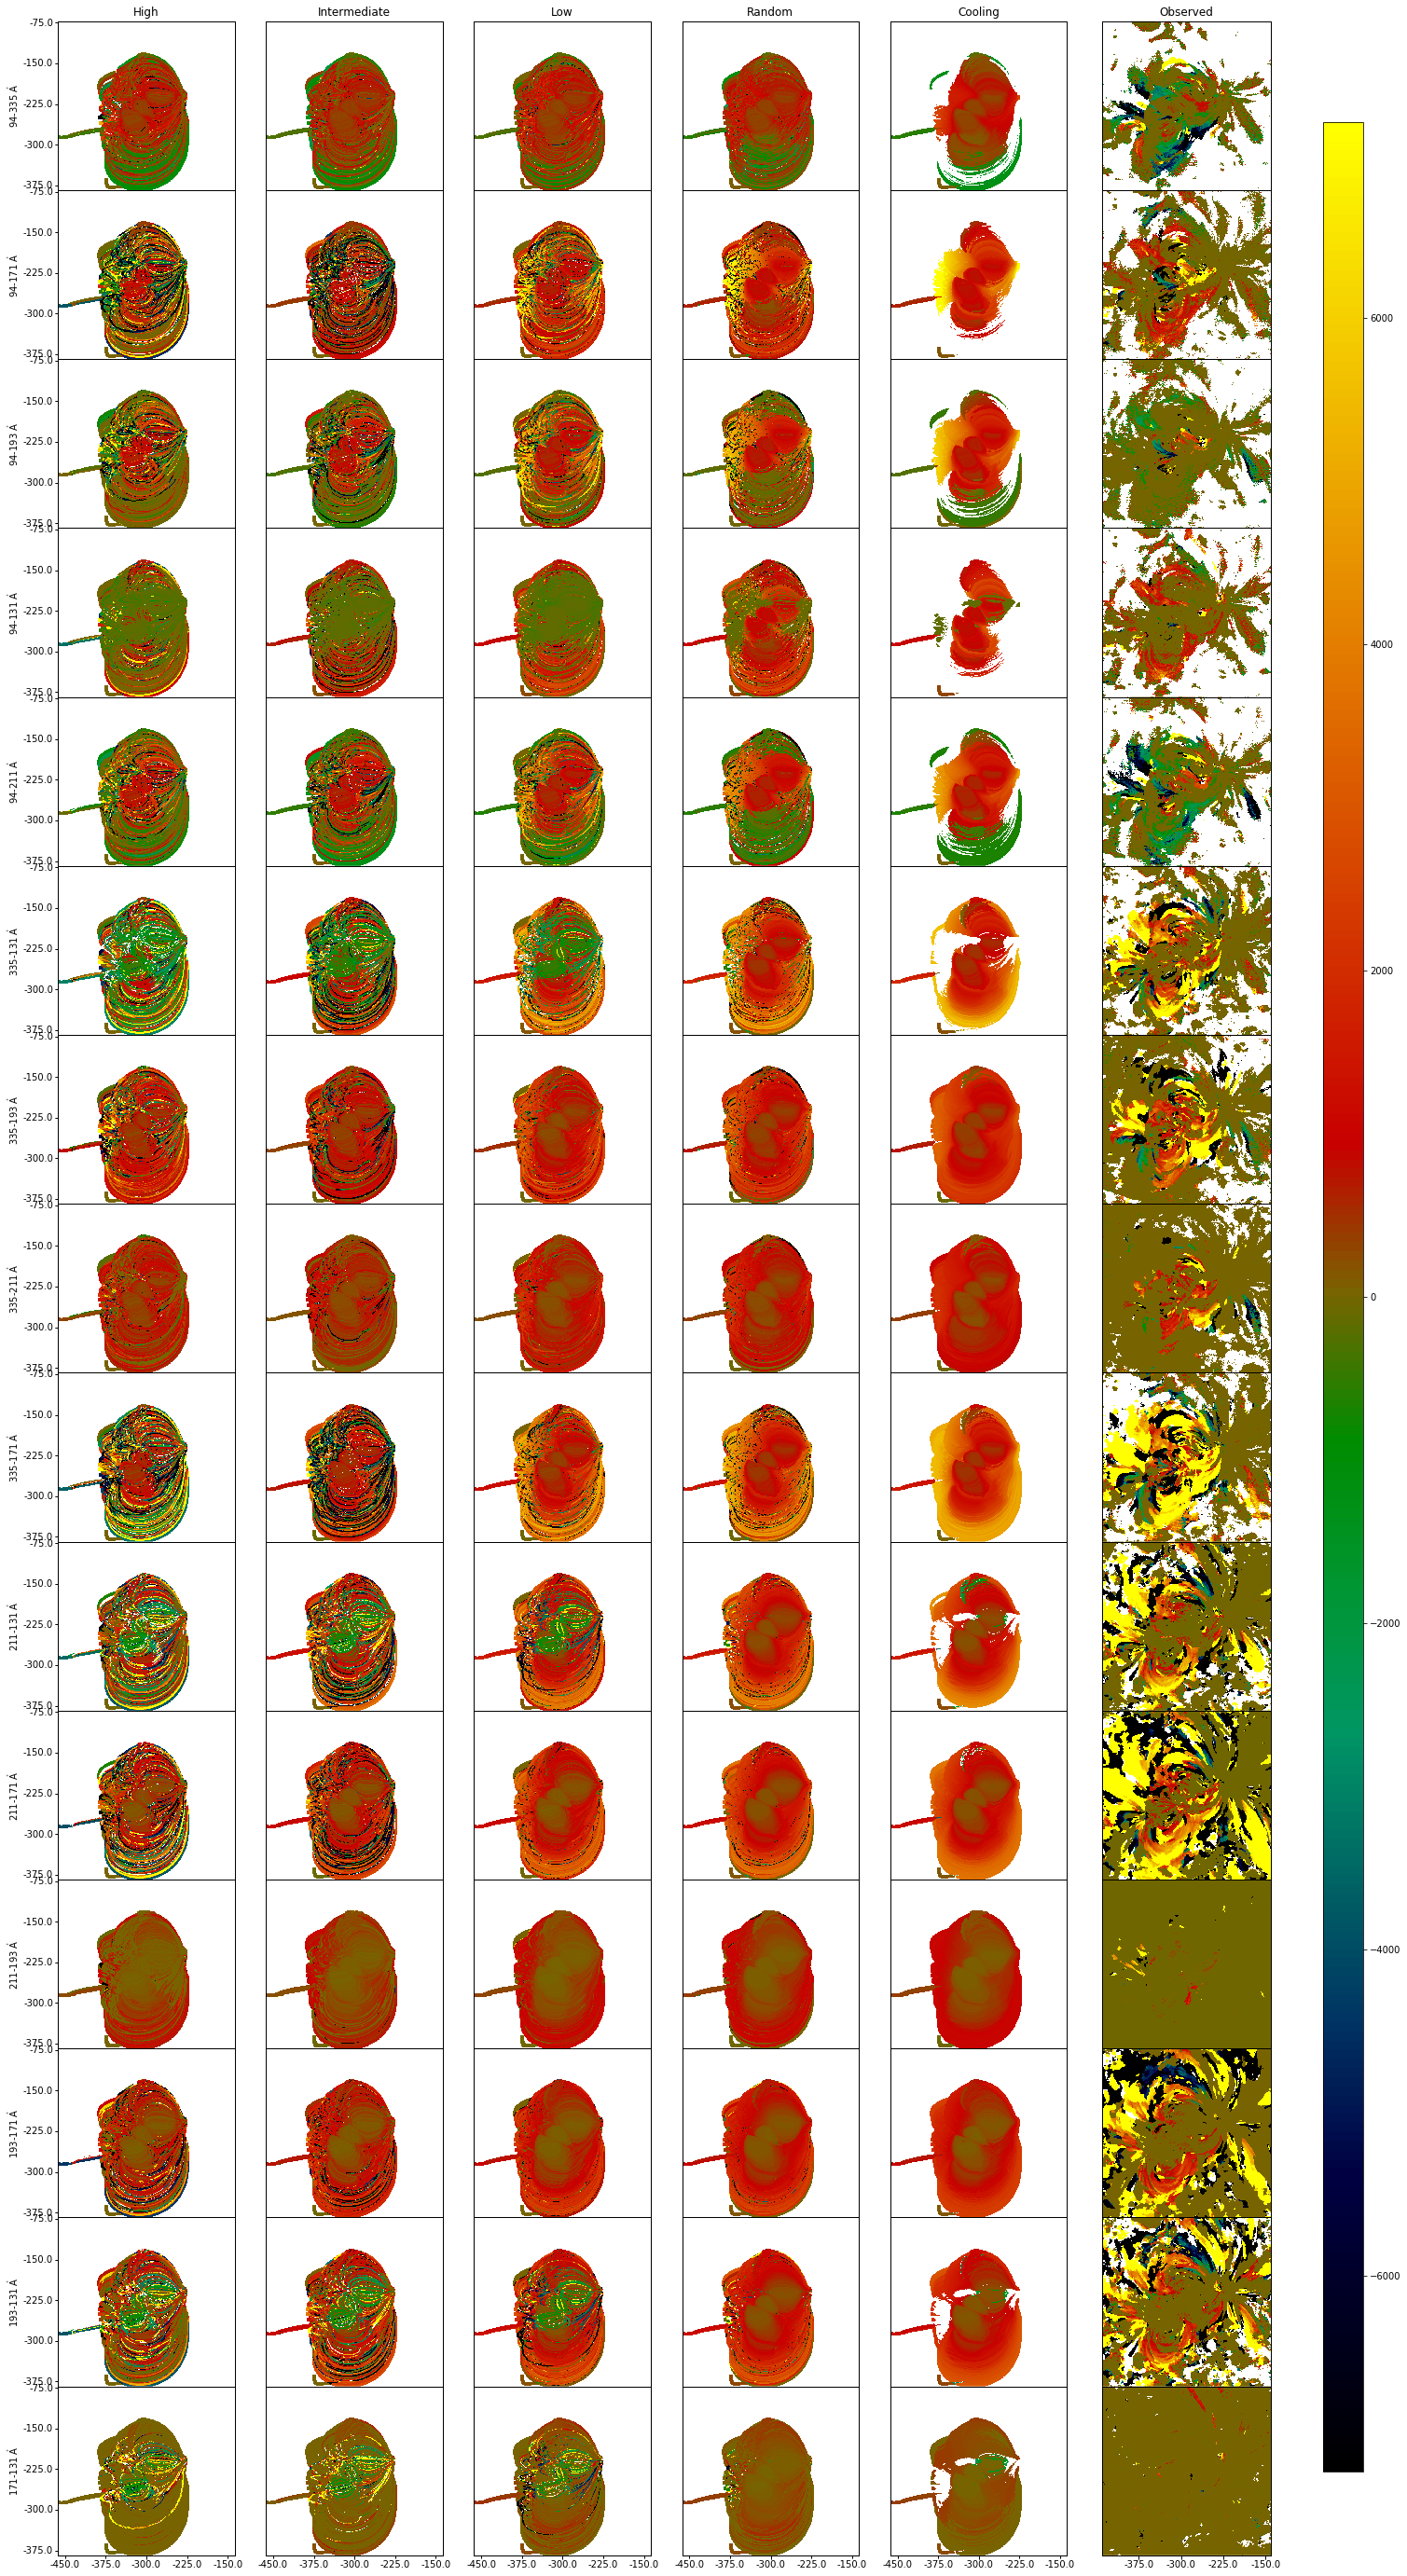

In [67]:
fig = plt.figure(figsize=(24,50))
plt.subplots_adjust(hspace=0,wspace=0)
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
map_plot_kwargs = {'cmap':bgry_004_idl_cmap,'vmin':(-2*u.hour).to(u.s).value,'vmax':(2*u.hour).to(u.s).value,}
for i,(c0,c1) in enumerate(channel_pairs):
    for j,h in enumerate(heating):
        tmp = timelags[h][f'{c0}_{c1}']
        tmp_cor = correlations[h][f'{c0}_{c1}']
        data = np.where((tmp_cor.data) < correlation_cutoff, np.nan, tmp.data)
        tmp = Map(data, tmp.meta)
        ax = fig.add_subplot(len(channel_pairs),6,6*i+j+1,projection=tmp)
        im = tmp.plot(annotate=False,title=False,**map_plot_kwargs)
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.grid(draw_grid=False)
        lat.grid(draw_grid=False)
        if j==0:
            lat.set_axislabel(f'{c0}-{c1} $\mathrm{{\mathring{{A}}}}$')
        if i<len(channel_pairs)-1:
            lon.set_ticklabel_visible(False)
            lon.set_ticks_visible(False)
        if j > 0:
            lat.set_ticklabel_visible(False)
            lat.set_ticks_visible(False)
        if i==0:
            ax.set_title(titles[h])
cbar = fig.colorbar(im, cax=cax)

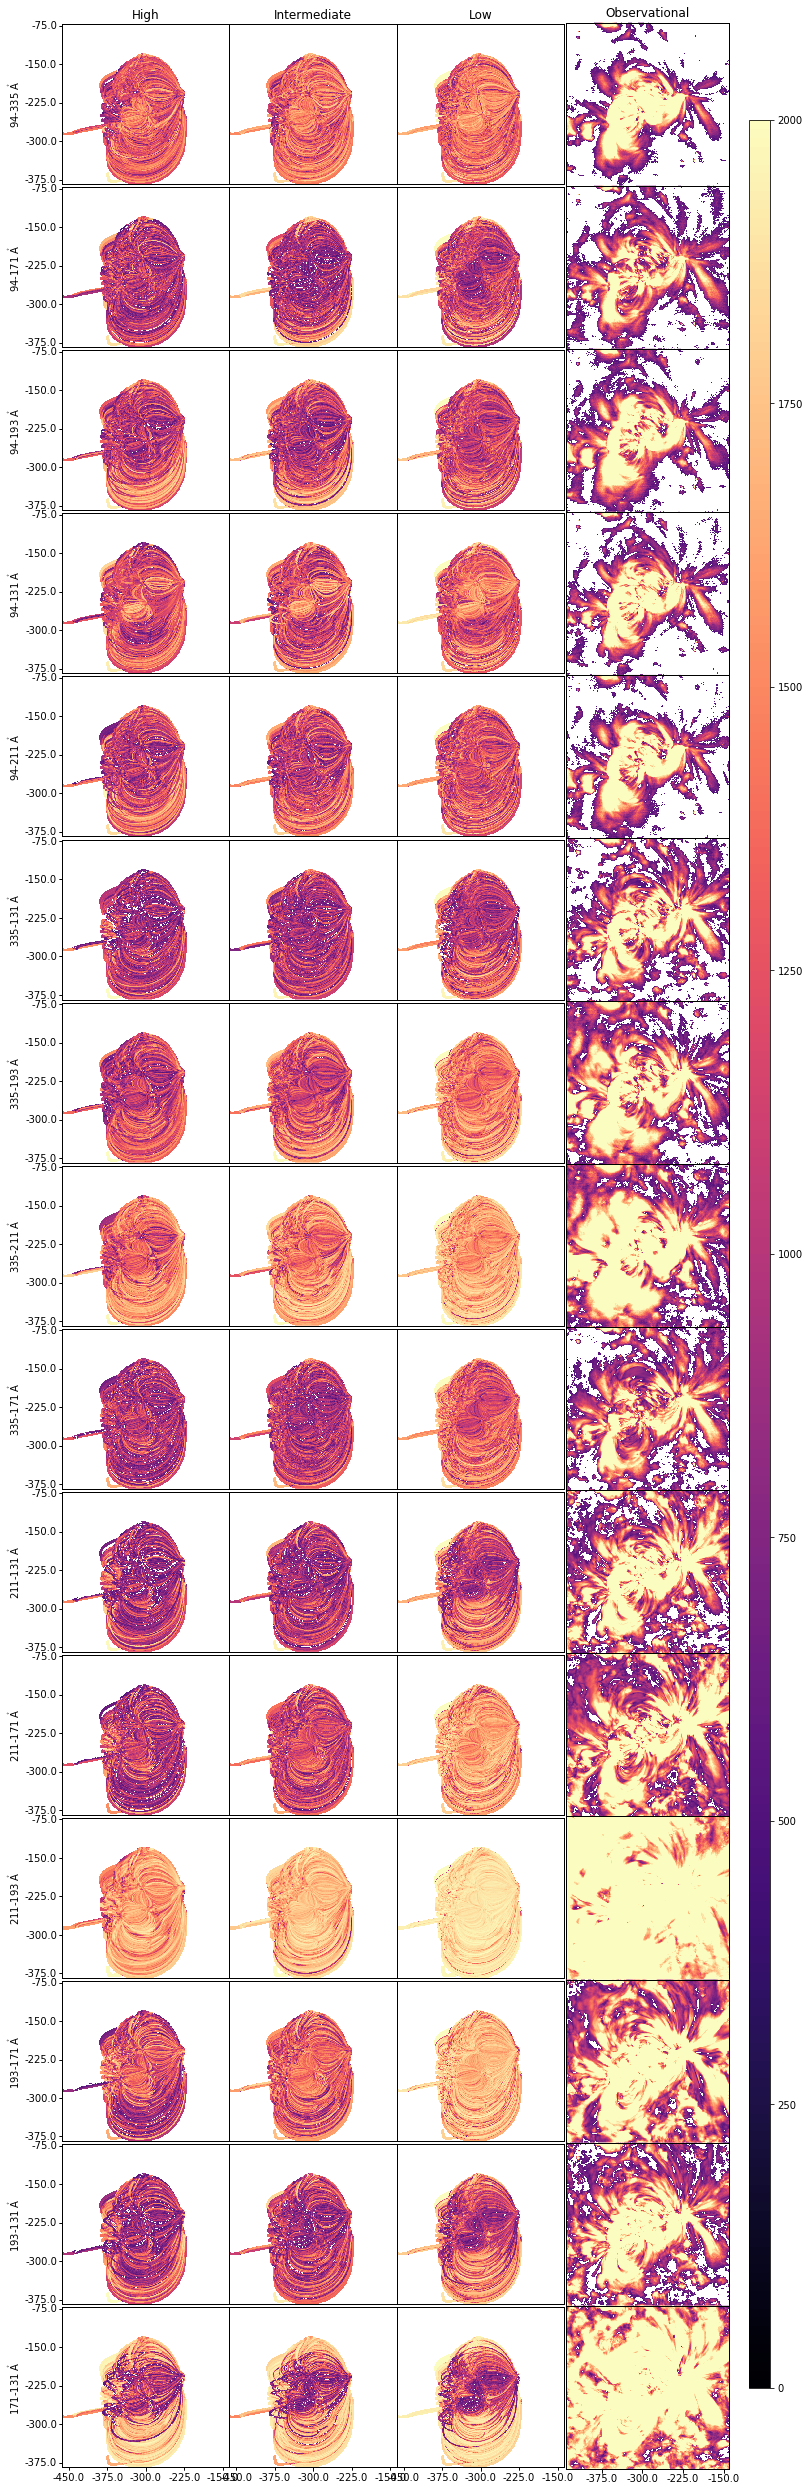

In [38]:
fig = plt.figure(figsize=(12,45))
plt.subplots_adjust(hspace=0,wspace=0)
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
map_plot_kwargs = {'cmap':'magma','vmin':0,'vmax':2e3,}
for i,(c0,c1) in enumerate(channel_pairs):
    for j,h in enumerate(heating):
        tmp = correlations[h][f'{c0}_{c1}']
        data = np.where((tmp.data) < correlation_cutoff, np.nan, tmp.data)
        tmp = Map(data, tmp.meta)
        ax = fig.add_subplot(len(channel_pairs),4,4*i+j+1,projection=tmp)
        im = tmp.plot(annotate=False,title=False,**map_plot_kwargs)
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.grid(draw_grid=False)
        lat.grid(draw_grid=False)
        if j==0:
            lat.set_axislabel(f'{c0}-{c1} $\mathrm{{\mathring{{A}}}}$')
        if i<len(channel_pairs)-1:
            lon.set_ticklabel_visible(False)
            lon.set_ticks_visible(False)
        if j > 0:
            lat.set_ticklabel_visible(False)
            lat.set_ticks_visible(False)
        if i==0:
            ax.set_title(h.split('_')[0].capitalize())
cbar = fig.colorbar(im, cax=cax)

## Timelag Distributions

Finally, compare them on a histogram

In [77]:
bins = np.linspace(-(2*u.hour).to(u.s).value, (2*u.hour).to(u.s).value, 100)

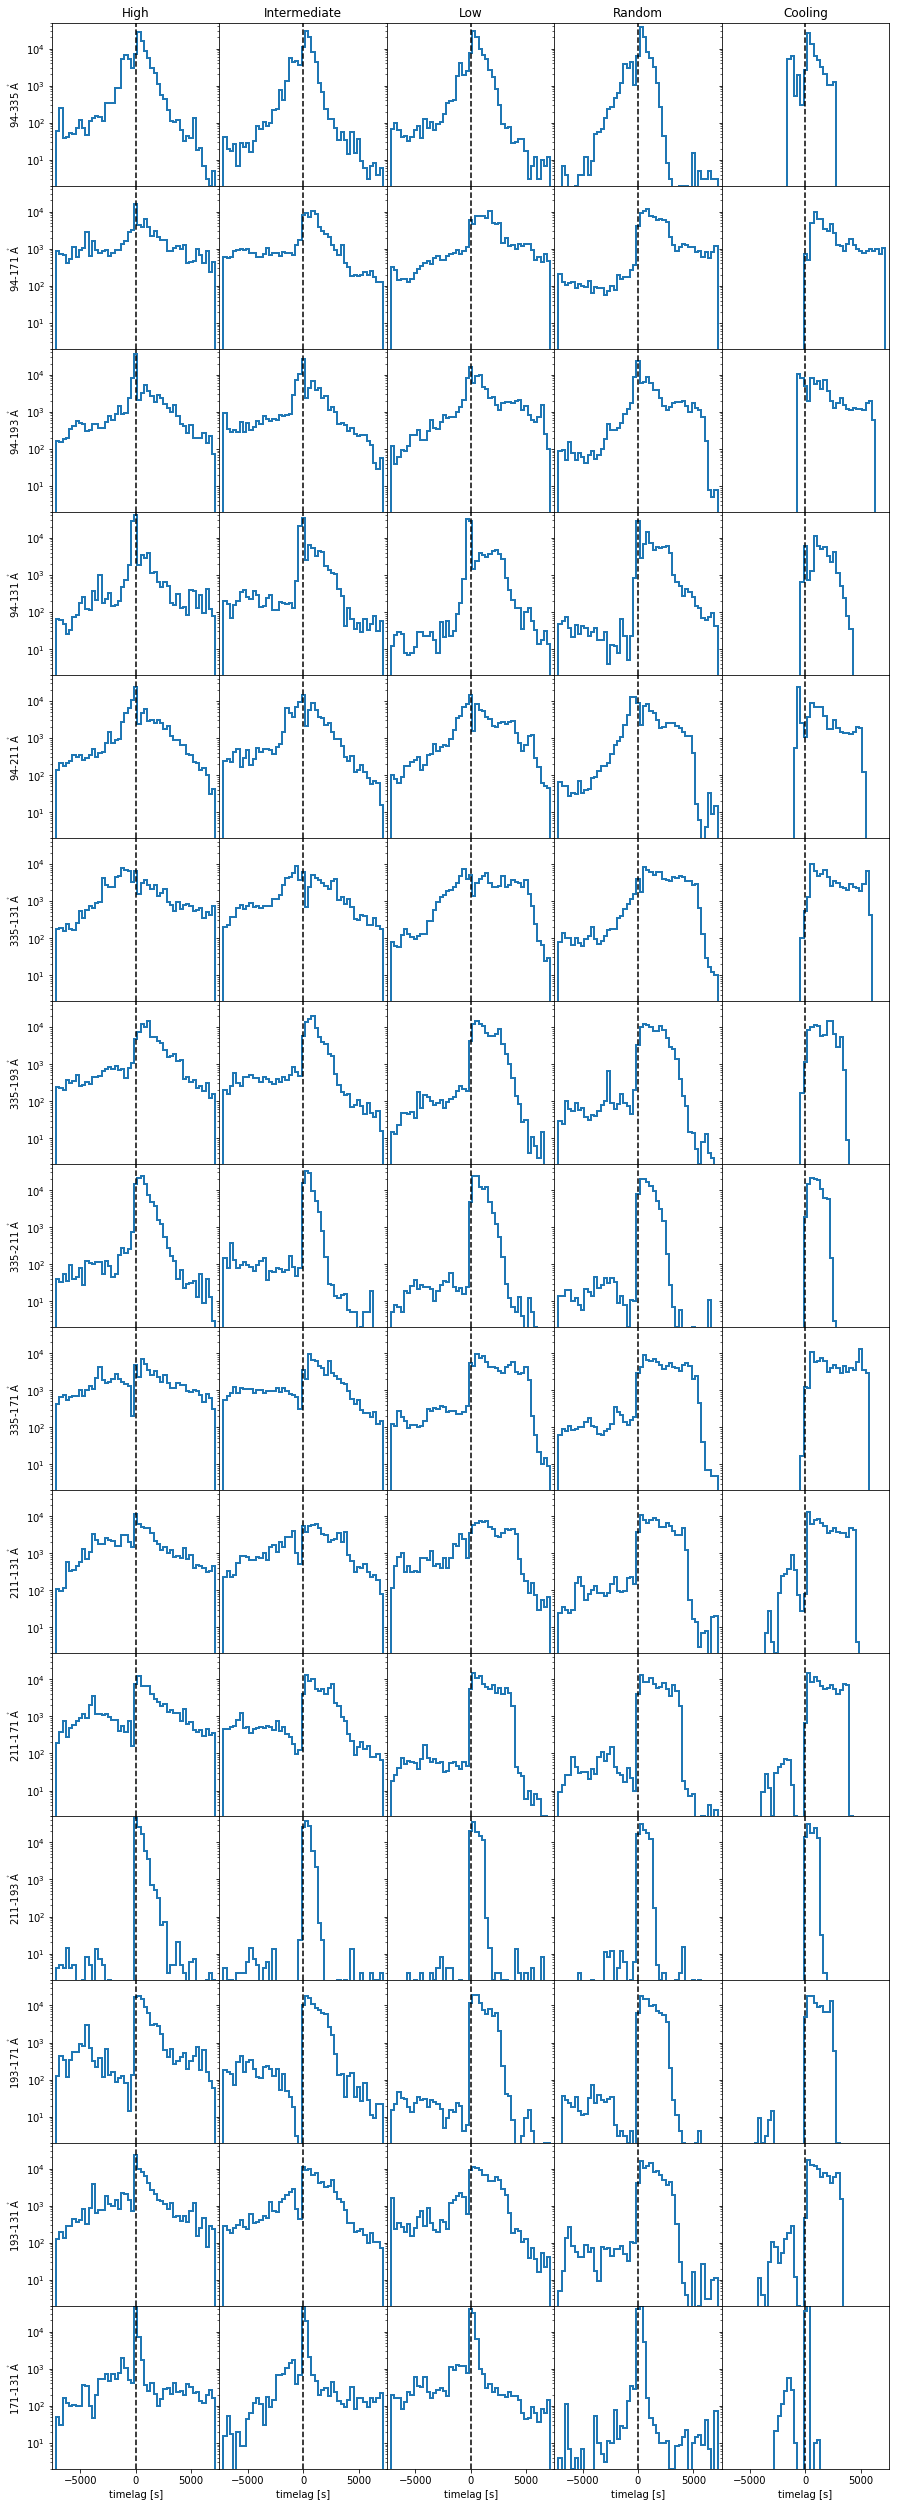

In [70]:
params = {'log':True,'bins':bins,'histtype':'step','lw':2,'cumulative':False,'color':'C0','ls':'-'}
fig,axes = plt.subplots(len(channel_pairs),5,figsize=(15,45),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
for i,(c0,c1) in enumerate(channel_pairs):
    for j,h in enumerate(heating[:-1]):
        ax = axes[i,j]
        tmp = timelags[h][f'{c0}_{c1}']
        data = tmp.data.flatten()
        tmp = correlations[h][f'{c0}_{c1}']
        data_cor = tmp.data.flatten()
        dist = data[np.where(data_cor >= correlation_cutoff)]
        ax.hist(dist, **params,)
        ax.axvline(x=0,ls='--',color='k')
        if j == 0:
            ax.set_ylabel(f'{c0}-{c1} $\mathrm{{\mathring{{A}}}}$')
        if i == len(channel_pairs)-1:
            ax.set_xlabel(r'timelag [s]')
        if i == 0:
            ax.set_title(titles[h])
axes[0,0].set_xlim(-(2.1*u.hour).to(u.s).value, (2.1*u.hour).to(u.s).value);
axes[0,0].set_ylim(2,5e4);

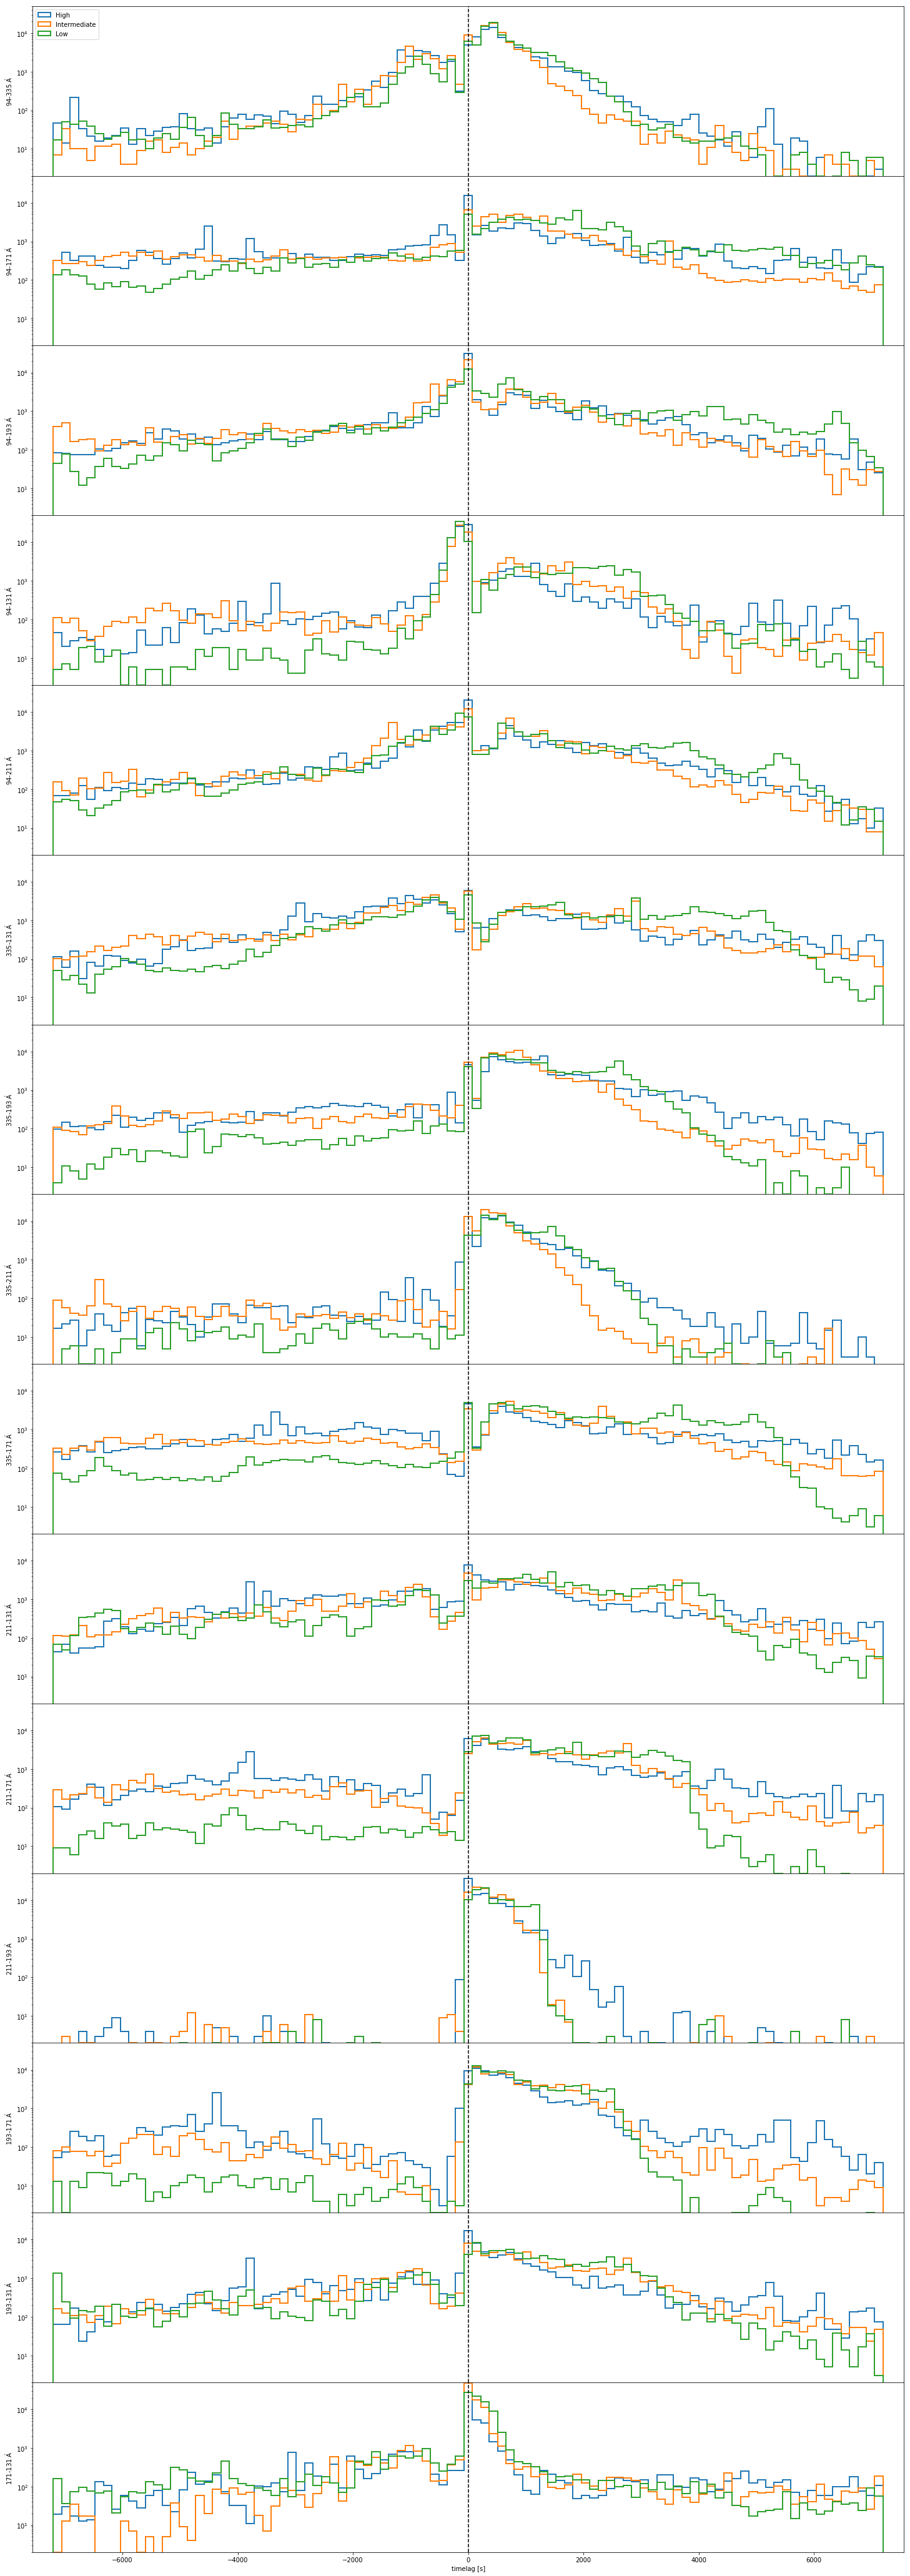

In [80]:
params = {'log':True,'bins':bins,'histtype':'step','lw':2,'cumulative':False,'color':'C0','ls':'-'}
fig,axes = plt.subplots(len(channel_pairs),1,figsize=(25,75),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.0,wspace=0.1)
for i,(ax,(c0,c1)) in enumerate(zip(axes.flatten(),channel_pairs)):
    for j,h in enumerate(heating[:-3]):
        tmp = timelags[h][f'{c0}_{c1}']
        data = tmp.data.flatten()
        tmp = correlations[h][f'{c0}_{c1}']
        data_cor = tmp.data.flatten()
        dist = data[np.where(data_cor >= correlation_cutoff)]
        params['color'] = f'C{j}'
        ax.hist(dist, **params,label=titles[h])
    ax.axvline(x=0,ls='--',color='k')
    ax.set_ylabel(f'{c0}-{c1} $\mathrm{{\mathring{{A}}}}$')
    if i == 0:
        ax.legend(loc=2)
    if i > 11:
        ax.set_xlabel(r'timelag [s]')
axes[0,].set_xlim(-(2.1*u.hour).to(u.s).value, (2.1*u.hour).to(u.s).value);
axes[0,].set_ylim(2,5e4);

## Computing Similarity to Observed Maps
One possible way to make a selection of the "best" heating model is to compute the observed timelags for all of these channels (using the same method as here) and then compute some sort of statistical distance between the distributions of timelags. A "pixel-by-pixel" comparison does not make much sense as this would likely be thrown off by the obvious issues with the field extrapolation and would not be a great test of the heating model itself.

Now, look at the maps.

In [22]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

In [81]:
ds = 0.5*u.Mm
stacked_coords = None
for loop in field.loops:
    knots, _ = splprep(loop.coordinates.cartesian.xyz.value)
    n_interp = int(np.ceil((loop.full_length/ds).decompose()))
    tmp = np.array(splev(np.linspace(0, 1, n_interp), knots))
    if stacked_coords is None:
        stacked_coords = tmp
    else:
        stacked_coords = np.hstack([stacked_coords, tmp])
stacked_coords = u.Quantity(stacked_coords, loop.coordinates.cartesian.xyz.unit)
stacked_coords = SkyCoord(x=stacked_coords[0,:],y=stacked_coords[1,:],z=stacked_coords[2,:],frame='heliographic_stonyhurst',representation='cartesian')

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [82]:
sample_obs_map = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/timelags/timelag_171_131.fits')

In [83]:
core_pixels = sample_obs_map.world_to_pixel(stacked_coords.transform_to('heliographic_stonyhurst').transform_to(sample_obs_map.coordinate_frame))

In [84]:
x_pixel_mask = core_pixels.x.value.round().astype(int)
y_pixel_mask = core_pixels.y.value.round().astype(int)
i_inbounds = np.where(np.logical_and(x_pixel_mask>=0, y_pixel_mask>=0))
x_pixel_mask = x_pixel_mask[i_inbounds]
y_pixel_mask = y_pixel_mask[i_inbounds]

In [85]:
def chi_squared_mod(data_1, data_2, bins, normed=False):
    """
    Modified chi-squared test (see Eq. 14.3.3 of Numerical Recipes)
    """
    ds_1,_ = np.histogram(data_1, bins=bins, normed=normed)
    ds_2,_ = np.histogram(data_2, bins=bins, normed=normed)
    w_1 = data_1.shape[0]
    w_2 = data_2.shape[0]
    numerator = (np.sqrt(w_1/w_2) * ds_2 - np.sqrt(w_2/w_1) * ds_1)**2
    denominator = ds_1 + ds_2
    # Exclude the cases of empty bins in both sets
    tot = numerator[denominator != 0] / denominator[denominator != 0]
    return tot.sum()

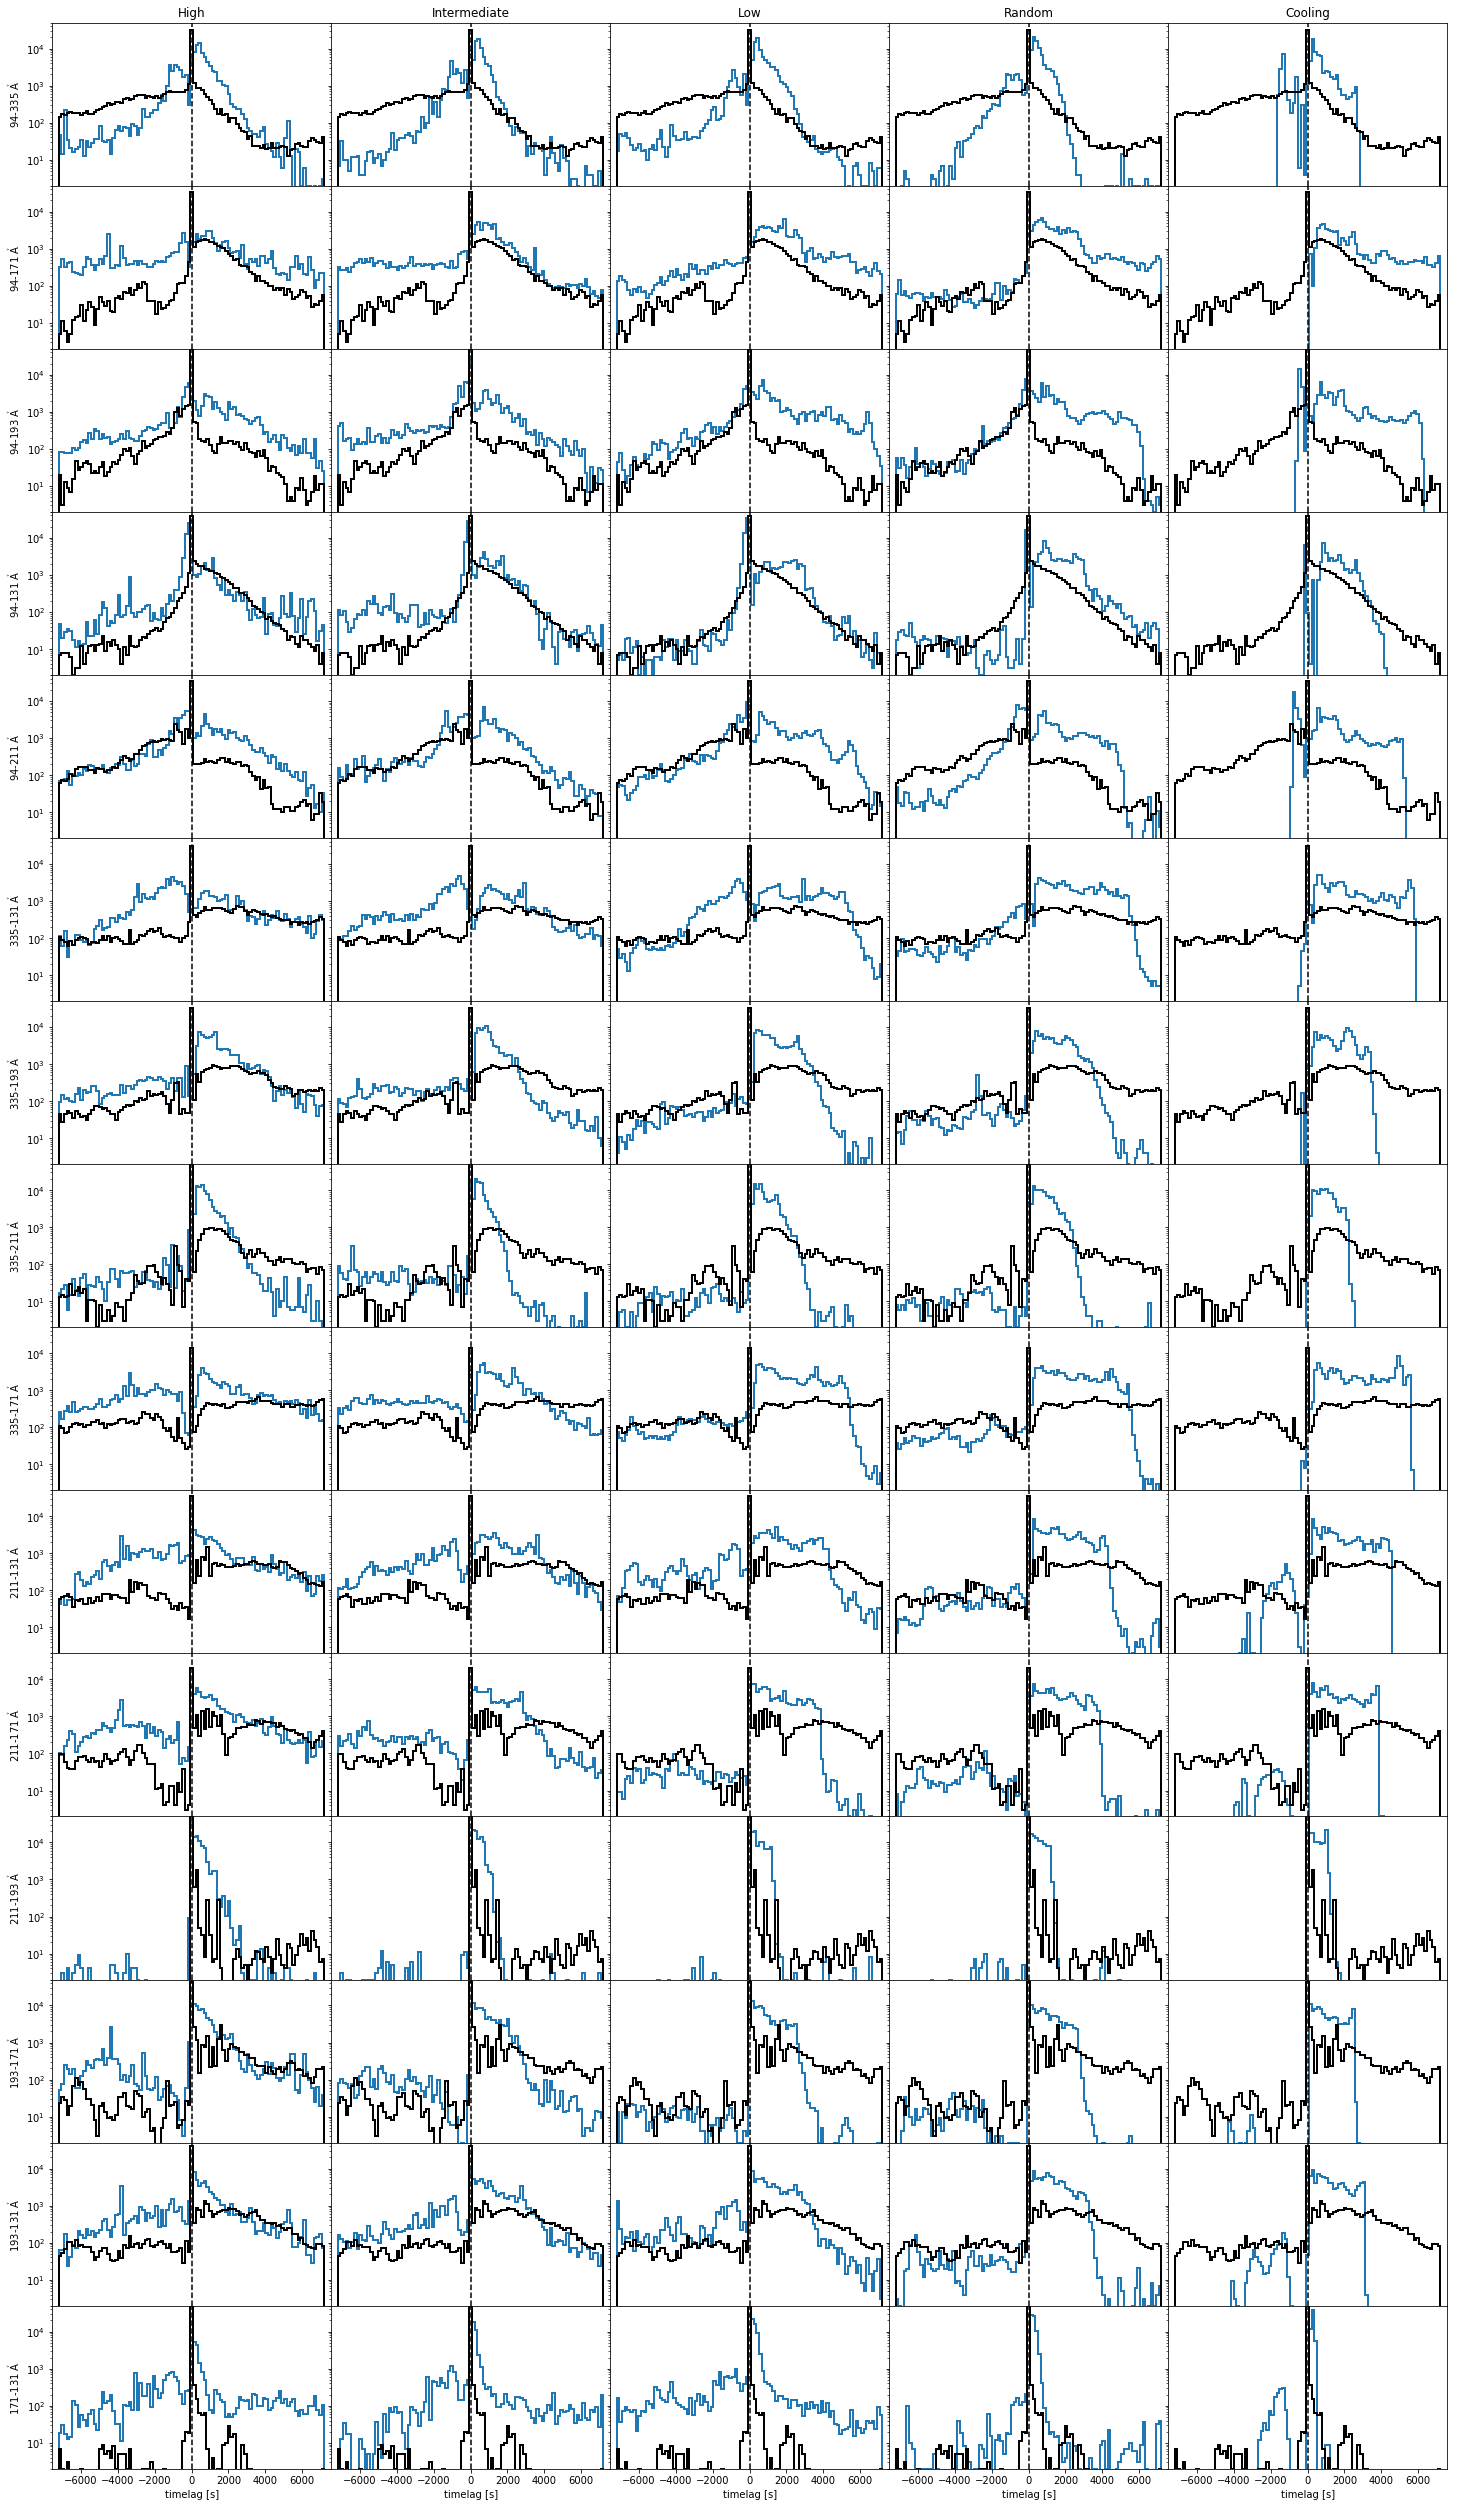

In [89]:
params = {'log':True,'bins':bins,'histtype':'step','lw':2,'cumulative':False,'color':'C0','ls':'-'}
params_obs = params.copy()
params_obs['color'] = 'k'
fig,axes = plt.subplots(len(channel_pairs),5,figsize=(25,45),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
for i,(c0,c1) in enumerate(channel_pairs):
    # Get the observed data
    tmp = timelags['observational_data'][f'{c0}_{c1}']
    mask = np.nan*np.ones(tmp.data.shape)
    mask[y_pixel_mask,x_pixel_mask] = tmp.data[y_pixel_mask,x_pixel_mask]
    tmp = Map(mask, tmp.meta)
    data = tmp.data.flatten()
    data = data[~np.isnan(data)]
    tmp = correlations['observational_data'][f'{c0}_{c1}']
    mask = np.nan*np.ones(tmp.data.shape)
    mask[y_pixel_mask,x_pixel_mask] = tmp.data[y_pixel_mask,x_pixel_mask]
    tmp = Map(mask, tmp.meta)
    data_cor = tmp.data.flatten()
    data_cor = data_cor[~np.isnan(data_cor)]
    data_observed = data[np.where(data_cor >= correlation_cutoff)]
    for j,h in enumerate(heating[:-1]):
        ax = axes[i,j]
        # Plot model results
        tmp = timelags[h][f'{c0}_{c1}']
        data = tmp.data.flatten()
        tmp = correlations[h][f'{c0}_{c1}']
        data_cor = tmp.data.flatten()
        data_model = data[np.where(data_cor >= correlation_cutoff)]
        ax.hist(data_model, **params,)
        ax.axvline(x=0,ls='--',color='k')
        # Plot observational results
        ax.hist(data_observed,**params_obs)
        # Compute statistical distance
        #ks_d,ks_p = scipy.stats.ks_2samp(data_observed, data_model)
        # Labels
        #ax.text(-6.5e3, 1e4, f'$D_{{KS}}={ks_d:.3f}$',fontsize=15)
        if j == 0:
            ax.set_ylabel(f'{c0}-{c1} $\mathrm{{\mathring{{A}}}}$')
        if i == len(channel_pairs)-1:
            ax.set_xlabel(r'timelag [s]')
        if i == 0:
            ax.set_title(titles[h])
axes[0,0].set_xlim(-(2.1*u.hour).to(u.s).value, (2.1*u.hour).to(u.s).value);
axes[0,0].set_ylim(2,5e4);